# FEgrow: An Open-Source Molecular Builder and Free Energy Preparation Workflow

**Authors: Mateusz K Bieniek, Ben Cree, Rachael Pirie, Joshua T. Horton, Natalie J. Tatum, Daniel J. Cole**

* Add chemical functional groups (R-groups) in user-defined positions
* Output ADMET properties
* Perform constrained optimisation
* Score poses
* Output structures for free energy calculations

## Overview

This notebook demonstrates the entire `FEgrow` workflow for generating a series of ligands with a common core for a specific binding site, via the addition of a user-defined set of R-groups. 

These *de novo* ligands are then subjected to ADMET analysis. Valid conformers of the added R-groups are enumerated, and optimised in the context of the receptor binding pocket, optionally using hybrid machine learning / molecular mechanics potentials (ML/MM).

An ensemble of low energy conformers is generated for each ligand, and scored using the `gnina` convolutional neural network (CNN). Output structures are saved as `pdb` files ready for use in free energy calculations.

The target for this tutorial is the main protease (Mpro) of SARS-CoV-2, and the core and receptor structures are taken from a [recent study by Jorgensen & co-workers](https://doi.org/10.1021/acscentsci.1c00039).

In [1]:
import copy

import prody
from rdkit import Chem

import fegrow
from fegrow import RGroups, RLinkers

molfile /home/dresio/code/fegrow/fegrow/data/linkers/s.mol
molfile /home/dresio/code/fegrow/fegrow/data/linkers/n.mol
molfile /home/dresio/code/fegrow/fegrow/data/linkers/co.mol


[13:17:32] Warning: molecule is tagged as 3D, but all Z coords are zero
[13:17:32] Warning: molecule is tagged as 3D, but all Z coords are zero
[13:17:32] Warning: molecule is tagged as 3D, but all Z coords are zero
[13:17:32] Warning: molecule is tagged as 3D, but all Z coords are zero
[13:17:32] Warning: molecule is tagged as 3D, but all Z coords are zero
[13:17:32] Warning: molecule is tagged as 3D, but all Z coords are zero
[13:17:32] Warning: molecule is tagged as 3D, but all Z coords are zero


# Prepare the ligand template

The provided core structure `lig.pdb` has been extracted from a crystal structure of Mpro in complex with compound **4** from the Jorgensen study (PDB: 7L10), and a Cl atom has been removed to allow growth into the S3/S4 pocket. The template structure of the ligand is protonated with [Open Babel](http://openbabel.org/wiki/Main_Page):

In [2]:
!obabel sarscov2/lig.pdb -O sarscov2/coreh.sdf -p 7

1 molecule converted


Load the protonated ligand into FEgrow:

In [3]:
init_mol = Chem.SDMolSupplier('sarscov2/coreh.sdf', removeHs=False)[0]

# get the FEgrow representation of the rdkit Mol
template_mol = fegrow.RMol(init_mol)

Show the 2D (with indices) representation of the core. This is used to select the desired growth vector.

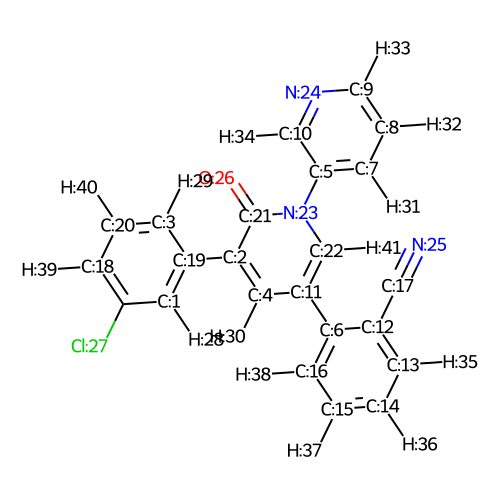

In [4]:
template_mol.rep2D(idx=True, size=(500, 500))

Using the 2D drawing, select an index for the growth vector. Note that it is currently only possible to grow from hydrogen atom positions. In this case, we are selecting the hydrogen atom labelled H:40 to enable growth into the S3/S4 pocket of Mpro.

In [5]:
attachment_index = [40]

R-groups can be selected interactively or programmaticaly.

We have provided a set of common R-groups (see `fegrow/data/rgroups/library`), which can be browsed and selected interactively below.

Molecules from the library can alternatively be selected by name, as demonstrated below.

Finally, user-defined R-groups may be provided as `.mol` files. *In this case, the hydrogen atom selected for attachment should be replaced by the element symbol R.* See the directory `manual_rgroups` for examples.

In [11]:
# interactive selection
RGroups

In [12]:
print(RGroups.get_selected())

[<rdkit.Chem.rdchem.Mol object at 0x7ff83d4d8ac0>, <rdkit.Chem.rdchem.Mol object at 0x7ff83d4b2820>]


In [13]:
RLinkers

In [14]:
RLinkers.get_selected()

In [16]:
# retrieve the interactively selected groups
interactive_rgroups = RGroups.get_selected()

# you can also directly access the built-in dataframe programmatically
groups = RGroups.dataframe
R_group_ethanol = groups.loc[groups['Name']=='*CCO']['Mol'].values[0]
R_group_cyclopropane = groups.loc[groups['Name'] == '*C1CC1' ]['Mol'].values[0]

# add your own R-groups files
R_group_propanol = Chem.MolFromMolFile('manual_rgroups/propan-1-ol-r.mol', removeHs=False)

# make a list of R-group molecule
selected_rgroups = [R_group_propanol, R_group_ethanol, R_group_cyclopropane] + interactive_rgroups
selected_rgroups

# Build a congeneric series

Now that the R-groups have been selected, we merge them with the ligand core:

In [17]:
rmols = fegrow.build_molecules(template_mol, 
                               attachment_index, 
                               selected_rgroups)

Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7ff83cfd6ca0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7ff83cfd6fa0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7ff83cfd6fa0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7ff83cfd6ca0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7ff83cfd6ca0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7ff83cfd6fa0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7ff83cfd6fa0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7ff83cfd6ca0>


,Smiles,Molecule
ID,,
0,[H]c1nc([H])c(-n2c([H])c(-c3c([H])c([H])c([H])...,
1,[H]OC([H])([H])C([H])([H])c1c([H])c(Cl)c([H])c...,
2,[H]c1nc([H])c(-n2c([H])c(-c3c([H])c([H])c([H])...,
3,[H]c1nc([H])c(-n2c([H])c(-c3c([H])c([H])c([H])...,

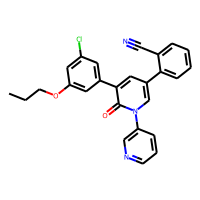
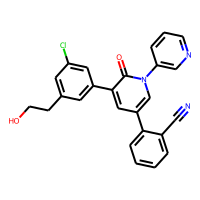
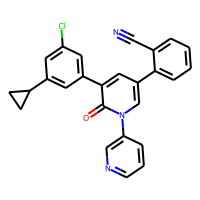
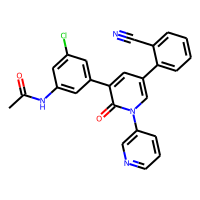

In [18]:
rmols

The R-group library can also be viewed as a 2D grid, or individual molecules can be selected for 3D view (note that the conformation of the R-group has not yet been optimised):

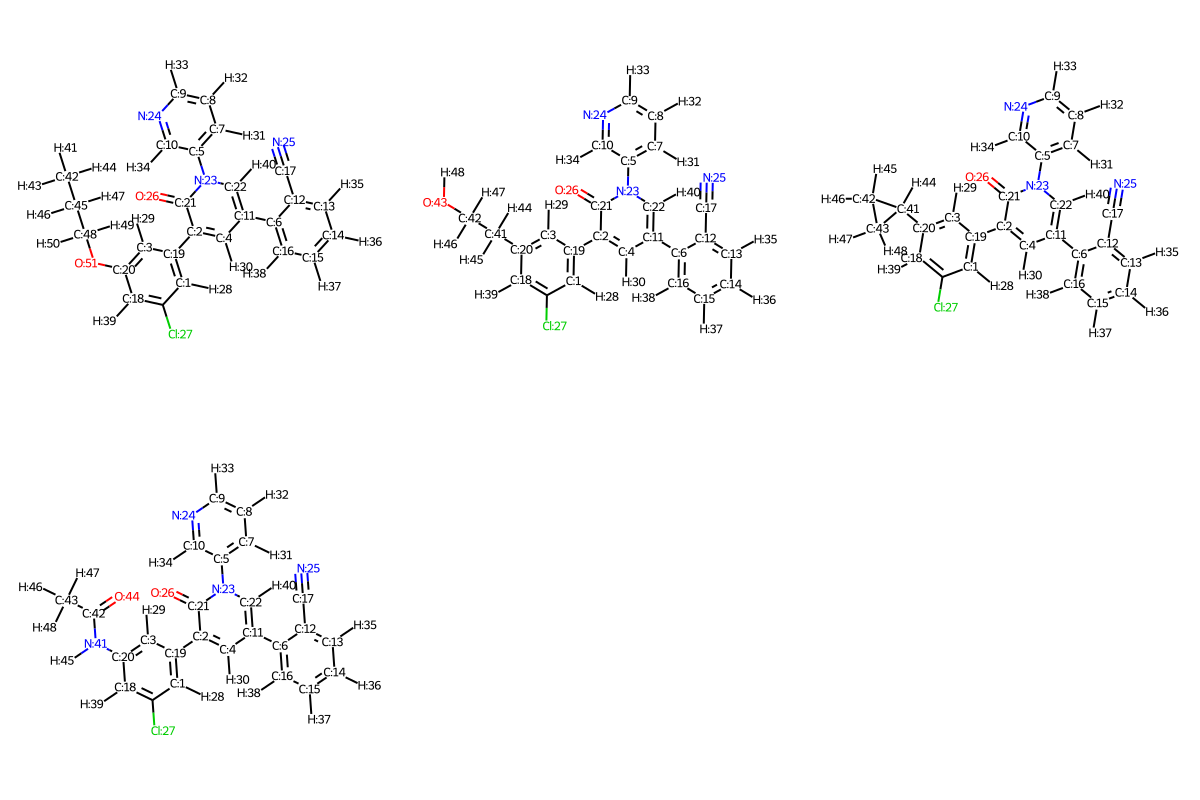

In [19]:
rmols.rep2D()

In [20]:
rmols[0].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Once the ligands have been generated, they can be assessed for various ADMET properties, including Lipinksi rule of 5 properties, the presence of unwanted substructures or problematic functional groups, and synthetic accessibility.

,MW,HBA,HBD,LogP,Pass_Ro5,has_pains,has_unwanted_subs,has_prob_fgs,synthetic_accessibility,Smiles,Molecule
ID,,,,,,,,,,,
0,441.124405,5,0,5.88038,True,False,False,True,7.634562,[H]c1nc([H])c(-n2c([H])c(-c3c([H])c([H])c([H])...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
1,427.108754,5,1,4.62638,True,False,False,True,7.501563,[H]OC([H])([H])C([H])([H])c1c([H])c(Cl)c([H])c...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
2,423.113840,4,0,5.96898,True,False,False,True,7.482970,[H]c1nc([H])c(-n2c([H])c(-c3c([H])c([H])c([H])...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
3,440.104003,5,1,5.04998,True,False,False,True,7.306830,[H]c1nc([H])c(-n2c([H])c(-c3c([H])c([H])c([H])...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"

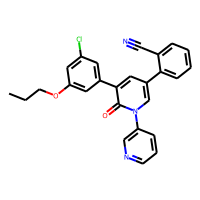
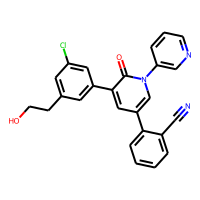
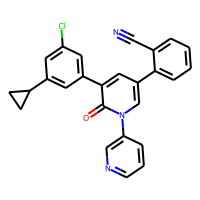
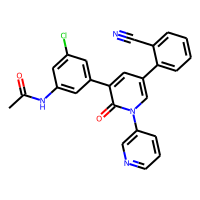

In [21]:
rmols.toxicity()

For each ligand, a specified number of conformers (`num_conf`) is generated by using the RDKit [ETKDG algorithm](https://doi.org/10.1021/acs.jcim.5b00654). Conformers that are too similar to an existing structure are discarded. Empirically, we have found that `num_conf=200` gives an exhaustive search, and `num_conf=50` gives a reasonable, fast search, in most cases.

If required, a third argument can be added `flexible=[0,1,...]`, which provides a list of additional atoms in the core that are allowed to be flexible. This is useful, for example, if growing from a methyl group and you would like the added R-group to freely rotate.

In [22]:
rmols.generate_conformers(num_conf=50, 
                          minimum_conf_rms=0.5, 
                          # flexible=[3, 18, 20])
                        )

RMol index 0
Removed 25 duplicated conformations, leaving 26 in total. 
RMol index 1
Removed 41 duplicated conformations, leaving 10 in total. 
RMol index 2
Removed 40 duplicated conformations, leaving 11 in total. 
RMol index 3
Removed 44 duplicated conformations, leaving 7 in total. 


### Prepare the protein

The protein-ligand complex structure is downloaded, and [PDBFixer](https://github.com/openmm/pdbfixer) is used to protonate the protein, and perform other simple repair:

In [23]:
# get the protein-ligand complex structure
!wget -nc https://files.rcsb.org/download/7L10.pdb

# load the complex with the ligand
sys = prody.parsePDB('7L10.pdb')

# remove any unwanted molecules
rec = sys.select('not (nucleic or hetatm or water)')

# save the processed protein
prody.writePDB('rec.pdb', rec)

# fix the receptor file (missing residues, protonation, etc)
fegrow.fix_receptor("rec.pdb", "rec_final.pdb")

# load back into prody
rec_final = prody.parsePDB("rec_final.pdb")

File ‘7L10.pdb’ already there; not retrieving.



@> 2609 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 4638 atoms and 1 coordinate set(s) were parsed in 0.05s.


View enumerated conformers in complex with protein:

In [24]:
rmols[0].rep3D(prody=rec_final)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Any conformers that clash with the protein (any atom-atom distance less than 1 Angstrom), are removed.

In [25]:
rmols.remove_clashing_confs(rec_final)

RMol index 0
Clash with the protein. Removing conformer id: 25
Clash with the protein. Removing conformer id: 20
Clash with the protein. Removing conformer id: 14
Clash with the protein. Removing conformer id: 11
Clash with the protein. Removing conformer id: 8
Clash with the protein. Removing conformer id: 5
Clash with the protein. Removing conformer id: 4
Clash with the protein. Removing conformer id: 3
RMol index 1
Clash with the protein. Removing conformer id: 2
Clash with the protein. Removing conformer id: 0
RMol index 2
RMol index 3


In [26]:
rmols[0].rep3D(prody=rec_final)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Optimise conformers in context of protein

The remaining conformers are optimised using hybrid machine learning / molecular mechanics (ML/MM), using the [ANI2x](https://doi.org/10.1021/acs.jctc.0c00121) neural nework potential for the ligand energetics (as long as it contains only the atoms H, C, N, O, F, S, Cl). Note that the Open Force Field [Parsley](https://doi.org/10.1021/acs.jctc.1c00571) force field is used for intermolecular interactions with the receptor.

`sigma_scale_factor`: is used to scale the Lennard-Jones radii of the atoms.

`relative_permittivity`: is used to scale the electrostatic interactions with the protein.

`water_model`: can be used to set the force field for any water molecules present in the binding site.

In [27]:
# opt_mol, energies
energies = rmols.optimise_in_receptor(
    receptor_file="rec_final.pdb", 
    ligand_force_field="openff", 
    use_ani=True,
    sigma_scale_factor=0.8,
    relative_permittivity=4,
    water_model = None
)

RMol index 0
using ani2x
/home/dresio/software/conda3/envs/rgroup/lib/python3.9/site-packages/torchani/resources/


Optimising conformer: 100%|█████████████████████| 18/18 [01:51<00:00,  6.17s/it]


RMol index 1
using ani2x
/home/dresio/software/conda3/envs/rgroup/lib/python3.9/site-packages/torchani/resources/


Optimising conformer: 100%|███████████████████████| 8/8 [00:30<00:00,  3.82s/it]


RMol index 2
using ani2x
/home/dresio/software/conda3/envs/rgroup/lib/python3.9/site-packages/torchani/resources/


Optimising conformer: 100%|█████████████████████| 11/11 [00:34<00:00,  3.13s/it]


RMol index 3
using ani2x
/home/dresio/software/conda3/envs/rgroup/lib/python3.9/site-packages/torchani/resources/


Optimising conformer: 100%|███████████████████████| 7/7 [00:46<00:00,  6.58s/it]


Any of the rmols that have no available conformers (due to unresolvable steric clashes with the protein) can be discarded using the `.discard_missing()` function. This function also returns a list of the indices that were removed, which can be helpful when carrying out data analysis.

In [28]:
missing_ids = rmols.discard_missing()

Optionally, display the final optimised conformers. Note that, unlike classical force fields, ANI allows bond breaking. You may occasionally see ligands with distorted structures and very long bonds, but in our experience these are rarely amongst the low energy structures and can be ignored.

In [29]:
rmols[0].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Conformers are now sorted by energy, only retaining those within 5 kcal/mol of the lowest energy structure:

In [30]:
final_energies = rmols.sort_conformers(energy_range=5)

RMol index 0
RMol index 1
RMol index 2
RMol index 3


Save all of the lowest energy conformers to files and print the sorted energies in kcal/mol (shifted so that the lowest energy conformer is zero).

In [31]:
[rmol.to_file(f"best_conformers{i}.pdb") for i, rmol in enumerate(rmols)]

[None, None, None, None]

In [32]:
print(final_energies)

                Energy
ID Conformer          
0  0          0.000000
   1          0.000298
   2          0.407626
   3          0.465169
   4          0.465191
   5          1.156675
   6          1.938205
   7          1.940075
   8          2.421440
   9          2.771812
   10         4.074946
   11         4.075592
1  0          0.000000
   1          3.096037
   2          3.276267
   3          4.038300
2  0          0.000000
   1          0.000158
   2          0.000244
   3          0.339632
   4          0.339757
   5          0.339903
   6          0.839741
   7          1.836269
   8          1.836307
   9          1.836626
   10         1.837537
3  0          0.000000
   1          1.563165
   2          2.188832


The conformers are scored using the [Gnina](https://github.com/gnina/gnina) molecular docking program and convolutional neural network scoring function. *[Note that this step is not supported on macOS].* If unavailable, the Gnina executable is downloaded during the first time it is used. The CNNscores may also be converted to predicted IC50 (nM) (see column "CNNaffinity->IC50s").

In [33]:
affinities = rmols.gnina(receptor_file="rec_final.pdb") 
affinities

RMol index 0
RMol index 1
RMol index 2
RMol index 3


CNNaffinity  CNNaffinity->IC50s
ID Conformer                                 
0  0              7.15984           69.208590
   1              7.15984           69.208590
   2              6.83832          145.104206
   3              7.17642           66.616222
   4              7.17635           66.626960
   5              7.07118           84.882859
   6              6.82012          151.314309
   7              6.82006          151.335216
   8              6.57573          265.625644
   9              6.91839          120.672970
   10             6.67819          209.802182
   11             6.67824          209.778029
1  0              6.57656          265.118479
   1              6.79288          161.109073
   2              6.76312          172.536109
   3              6.56137          274.555406
2  0              7.01796           95.948900
   1              7.01800           95.940063
   2              7.01803           95.933436
   3              6.81746          152.243935
   4              6.81714          152.356154
   5              6.81726          152.314062
   6              6.31885          479.899171
   7              7.04743           89.654068
   8              7.04740           89.660261
   9              7.04741           89.658197
   10             7.04729           89.682974
3  0              6.96874          107.463257
   1              6.77549          167.691095
   2              6.92975          117.557408

Predicted binding affinities may be further refined using the structures output by `FEgrow`, using your favourite free energy calculation engine. See our paper for an example using [SOMD](https://github.com/michellab/Sire) to calculate the relative binding free energies of 13 Mpro inhibitors.